In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from os.path import dirname, join
import networkx as nx

from graspy.plot import heatmap
from graspy.utils import get_multigraph_intersect_lcc, is_symmetric, symmetrize

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from utils import estimate_block_assignment, to_distance_mtx, identity, sort_graph, binarize, pvalue, block_permute, _sort_inds

### Preprocessing

In [2]:
left = np.loadtxt('../data/drosophila/left_adjacency.csv', dtype=int)
right = np.loadtxt('../data/drosophila/right_adjacency.csv', dtype=int)

with open('../data/drosophila/unweighted_drosophilia_match.pkl', 'rb') as f:
    graph_match = pickle.load(f)
graph_match = np.reshape(graph_match, (213, 213))

# left and right, binarized and symmetrized
left = binarize(symmetrize(left))
right = binarize(symmetrize(right))

right_nx = nx.from_numpy_matrix(right)
right_nx.remove_nodes_from(np.where(graph_match==1)[1][left.shape[0]:])
# right (removed nodes, not sorted)
right_rm = nx.to_numpy_array(right_nx)

# right (removed nodes and sorted)
right_sorted = sort_graph(right_rm, np.where(graph_match==1)[1][:left.shape[0]])

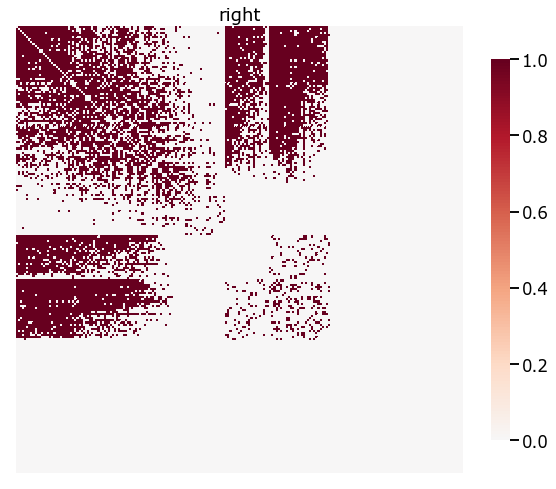

In [3]:
heatmap(right, title='right')

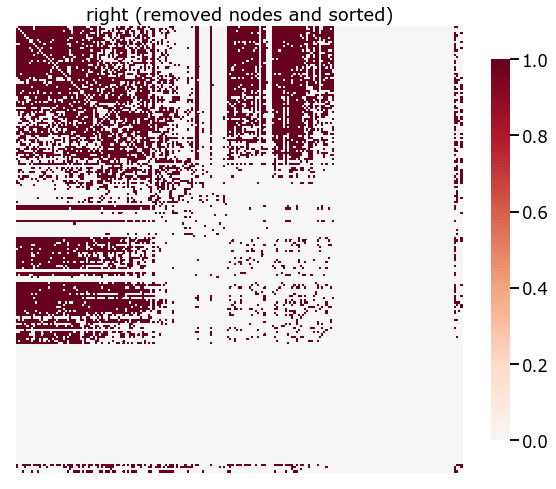

In [4]:
heatmap(right_sorted, title='right (removed nodes and sorted)')

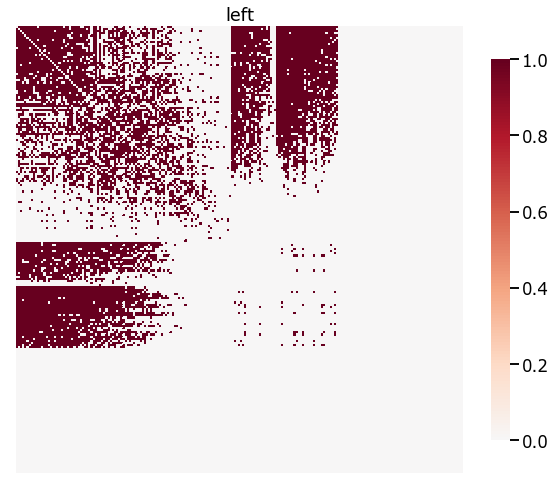

In [5]:
heatmap(left, title='left')

In [17]:
block_assignment = estimate_block_assignment(left, right_sorted, k=10, set_k=False, num_repeats=10)

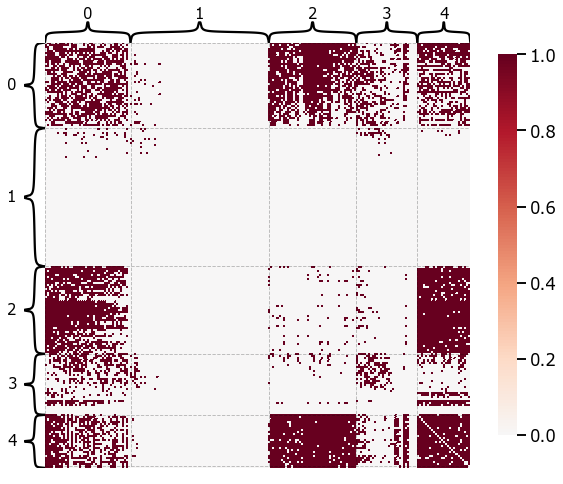

In [18]:
heatmap(left, inner_hier_labels=block_assignment, title='left')

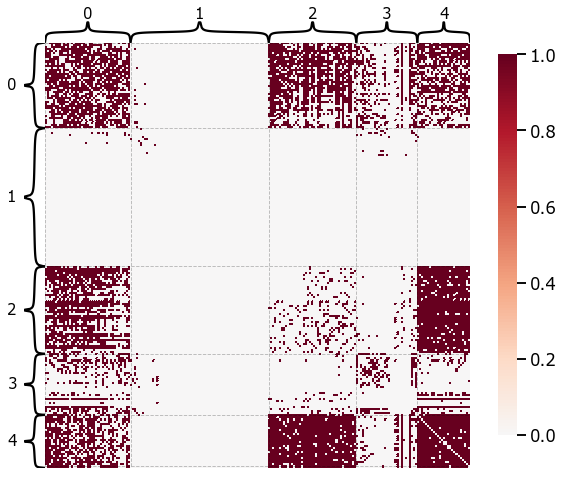

In [19]:
heatmap(right_sorted, inner_hier_labels=block_assignment)

### Fit model

In [9]:
mgc = MGC(compute_distance_matrix=identity)

In [56]:
pval = pvalue(A=left, B=right_sorted, indept_test=mgc, transform_func=to_distance_mtx, block_est_repeats=100,
             k=10, set_k=False)

In [57]:
pval

0.0

In [20]:
mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_sorted))

(0.5970284348018199,
 {'local_correlation_matrix': array([[0.59702843, 0.55303397],
         [0.55709532, 0.44819867]]), 'optimal_scale': [1, 1]})

In [22]:
mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right[:left.shape[0], :left.shape[0]]))

(0.5619846337845182,
 {'local_correlation_matrix': array([[0.56198463, 0.50398256],
         [0.50448054, 0.37542811]]), 'optimal_scale': [1, 1]})

In [73]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
k_arr = np.logspace(start=1, stop=7, num=7, base=2, dtype=int)
reps = 100
test_stats_null_arr = np.zeros((k_arr.size, reps))
for i, k in tqdm(enumerate(k_arr)):
    for r in range(reps):
        block_assignment = estimate_block_assignment(left, right_sorted, k=k, set_k=True, num_repeats=50)
        test_stats_null, _ = mgc.test_statistic(to_distance_mtx(block_permute(left, block_assignment)), 
                   to_distance_mtx(sort_graph(right_sorted, block_assignment)))
        test_stats_null_arr[i, r] = test_stats_null

7it [32:21, 402.83s/it]


[]

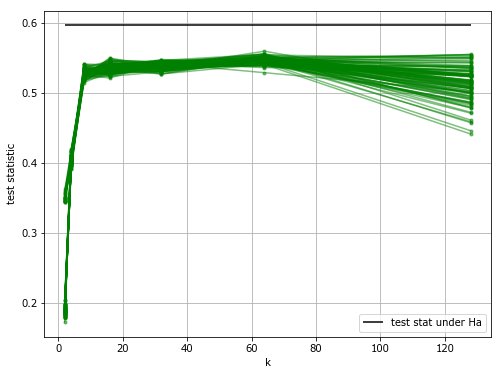

In [80]:
test_stats_alt = mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_sorted))[0]
plt.figure(figsize=(8, 6))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='.', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='test stat under Ha')
plt.xlabel('k')
plt.ylabel('test statistic')
plt.legend(loc=4)
plt.grid()
plt.plot()

### Weighted

In [6]:
with open('../data/drosophila/weighted_drosophilia_match.pkl', 'rb') as f:
    w_graph_match = pickle.load(f)
w_graph_match = np.reshape(w_graph_match, (213, 213))

In [11]:
np.where(w_graph_match==1)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [14]:
left_labels = np.loadtxt('../data/drosophila/left_cell_labels.csv', dtype=str)
right_labels = np.loadtxt('../data/drosophila/right_cell_labels.csv', dtype=str)

In [15]:
left_labels

array(['K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P

In [18]:
right_labels

array(['K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P

In [17]:
right_labels[np.where(w_graph_match==1)[1]]

array(['I', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'O', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'O', 'K', 'I',
       'K', 'K', 'K', 'K', 'K', 'I', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'K', 'I', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',
       'P', 'K', 'K', 'K', 'K', 'P', 'K', 'K', 'I', 'O', 'K', 'K', 'K',
       'K', 'K', 'K', 'K', 'P', 'K', 'K', 'K', 'K', 'O', 'O', 'O', 'O',
       'O', 'K', 'I', 'O', 'O', 'I', 'I', 'K', 'I', 'I', 'I', 'K', 'O',
       'K', 'K', 'P', 'I', 'O', 'O', 'O', 'O', 'I', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'I',
       'O', 'I', 'I', 'P', 'K', 'I', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P

In [21]:
np.unique(left_labels, return_counts=True)

(array(['I', 'K', 'O', 'P'], dtype='<U1'), array([ 21, 101,  29,  58]))

In [20]:
np.unique(right_labels, return_counts=True)

(array(['I', 'K', 'O', 'P'], dtype='<U1'), array([ 21, 100,  29,  63]))

In [25]:
P = np.zeros((213, 213))
for label in ['I', 'O']:
    left_idx = np.where(left_labels==label)[0]
    right_idx = np.where(right_labels==label)[0]
    P[left_idx, right_idx] = 1

In [30]:
np.where(left_labels=='I')

(array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121]),)

In [31]:
np.where(right_labels=='I')

(array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120]),)

In [49]:
left = np.loadtxt('../data/drosophila/left_adjacency.csv', dtype=int)
right = np.loadtxt('../data/drosophila/right_adjacency.csv', dtype=int)

# left and right, symmetrized
left = symmetrize(left)
right = symmetrize(right)

right_nx = nx.from_numpy_matrix(right)
right_nx.remove_nodes_from(np.where(w_graph_match==1)[1][left.shape[0]:])
# right (removed nodes, not sorted)
right_rm = nx.to_numpy_array(right_nx)

# right (removed nodes and sorted)
right_sorted = sort_graph(right_rm, np.where(w_graph_match==1)[1][:left.shape[0]])

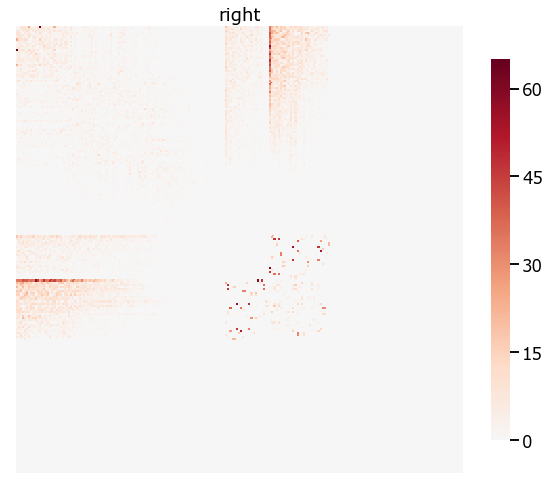

In [50]:
heatmap(right, title='right')

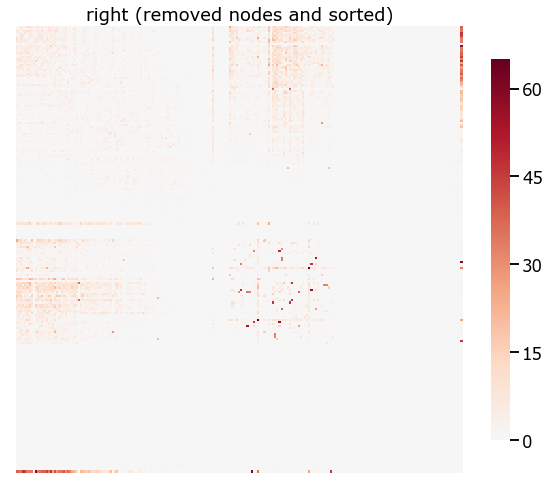

In [51]:
heatmap(right_sorted, title='right (removed nodes and sorted)')

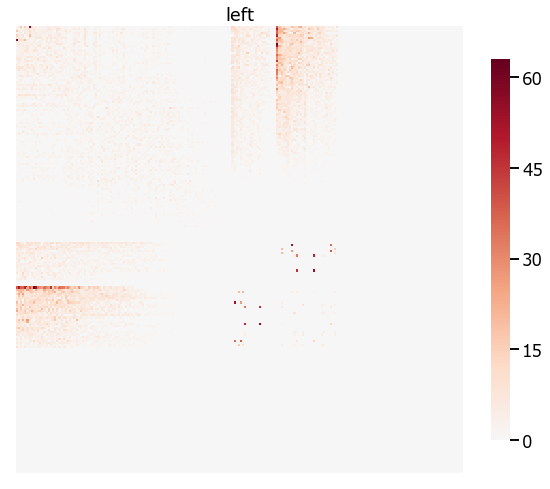

In [52]:
heatmap(left, title='left')

In [39]:
block_assignment = estimate_block_assignment(left, right_sorted, k=100, set_k=False, num_repeats=10)

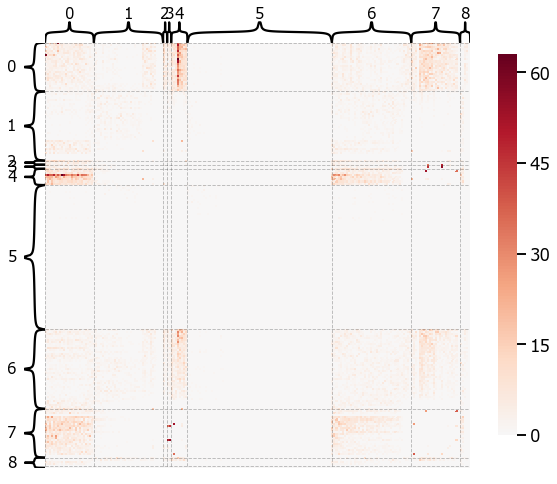

In [40]:
heatmap(left, inner_hier_labels=block_assignment, title='left')

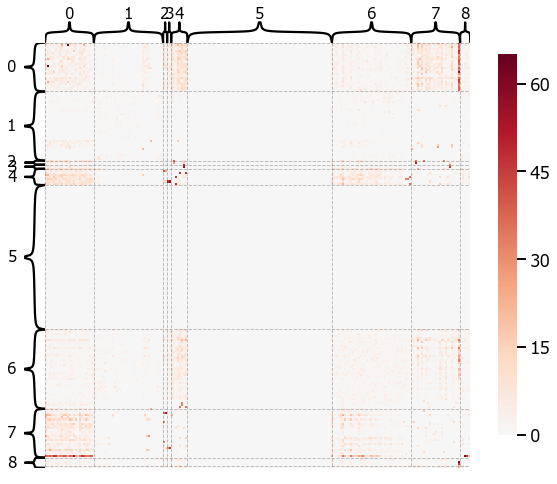

In [41]:
heatmap(right_sorted, inner_hier_labels=block_assignment)

### Fit model

In [53]:
mgc = MGC(compute_distance_matrix=identity)

In [72]:
pval, khat = pvalue(A=left, B=right_sorted, indept_test=mgc, transform_func=to_distance_mtx, block_est_repeats=100,
             k=64, set_k=False)

In [73]:
pval

0.0

In [54]:
mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_sorted))

(0.2532985913156812,
 {'local_correlation_matrix': array([[-4.58074942e-05, -5.22336414e-04, -6.17143451e-04, ...,
          -4.39547251e-03, -4.39423756e-03, -4.32231917e-03],
         [-4.90263470e-04, -2.66126025e-03,  1.74367025e-02, ...,
           1.13235447e-01,  1.13245856e-01,  1.13735971e-01],
         [-6.44921171e-04, -3.50866284e-03,  1.15715235e-02, ...,
           1.22702450e-01,  1.22716835e-01,  1.23417070e-01],
         ...,
         [-2.57346855e-03,  7.00997095e-03,  3.31396614e-02, ...,
           2.26245879e-01,  2.26284016e-01,  2.27979085e-01],
         [-2.57286058e-03,  7.01711033e-03,  3.31482380e-02, ...,
           2.26222614e-01,  2.26260737e-01,  2.27954985e-01],
         [-2.51061516e-03,  7.66214223e-03,  3.32313393e-02, ...,
           2.25401801e-01,  2.25438405e-01,  2.27049485e-01]]),
  'optimal_scale': [14, 13]})

In [55]:
mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right[:left.shape[0], :left.shape[0]]))

(0.3495643012308414,
 {'local_correlation_matrix': array([[-4.58074942e-05, -5.24656595e-04, -6.18750694e-04, ...,
           9.68878587e-03,  9.68977266e-03,  9.73706517e-03],
         [-4.90263470e-04,  2.46356120e-02,  9.75491909e-02, ...,
           1.78030605e-01,  1.78039856e-01,  1.78416089e-01],
         [-6.44921171e-04,  1.54778076e-02,  8.68072586e-02, ...,
           1.97429192e-01,  1.97442010e-01,  1.98011160e-01],
         ...,
         [-1.11053655e-03,  4.73072006e-03,  9.80986475e-02, ...,
           3.25969520e-01,  3.26055227e-01,  3.27308855e-01],
         [-1.10992026e-03,  4.73787800e-03,  9.81076154e-02, ...,
           3.25946557e-01,  3.26032249e-01,  3.27285055e-01],
         [-1.05028015e-03,  1.78868973e-03,  9.62007500e-02, ...,
           3.24909948e-01,  3.24994039e-01,  3.26327044e-01]]),
  'optimal_scale': [16, 13]})

In [42]:
k_arr = np.logspace(start=1, stop=7, num=7, base=2, dtype=int)

In [77]:
reps = 100
test_stats_null_arr = np.zeros((k_arr.size, reps))
for i, k in tqdm(enumerate(k_arr)):
    for r in range(reps):
        block_assignment = estimate_block_assignment(left, right_sorted, k=k, set_k=True, num_repeats=50)
        test_stats_null, _ = mgc.test_statistic(to_distance_mtx(block_permute(left, block_assignment)), 
                   to_distance_mtx(sort_graph(right_sorted, block_assignment)))
        test_stats_null_arr[i, r] = test_stats_null

7it [28:12, 323.13s/it]


In [83]:
test_stats_null_arr = np.load('../results/drosophila_weighted_teststats_null.npy')

In [96]:
def pval_from_null_dist(k):
    i = np.where(k_arr == k)[0][0]
    pval = np.where(test_stats_null_arr[i, :] >= test_stats_alt)[0].size / test_stats_null_arr.shape[1]
    return pval

In [99]:
for k in k_arr:
    print('k: {}, p-value: {}'.format(k, pval_from_null_dist(k)))

k: 2, p-value: 0.0
k: 4, p-value: 0.0
k: 8, p-value: 0.0
k: 16, p-value: 0.02
k: 32, p-value: 0.12
k: 64, p-value: 0.05
k: 128, p-value: 0.09


[]

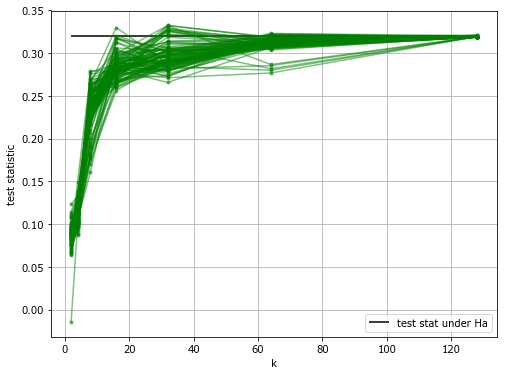

In [84]:
test_stats_alt = mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right_sorted))[0]
plt.figure(figsize=(8, 6))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='.', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='test stat under Ha')
plt.xlabel('k')
plt.ylabel('test statistic')
plt.legend(loc=4)
plt.grid()
plt.plot()

In [44]:
with open('../results/drosophila_weighted_teststats_null.pkl', 'rb') as f:
    null = pickle.load(f)
null = dict(null)

test_stats_null_arr = np.zeros((k_arr.size, 500))
for i, k in enumerate(k_arr):
    test_stats_null_arr[i, :] = null[k]

[]

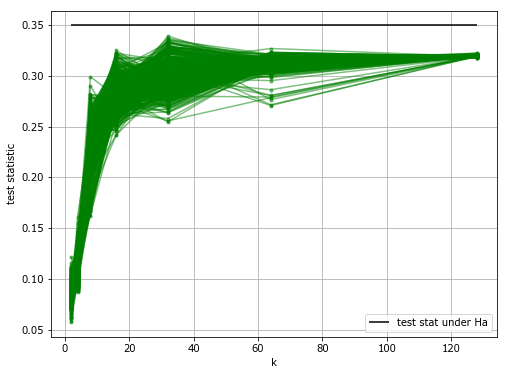

In [57]:
test_stats_alt, _ = mgc.test_statistic(to_distance_mtx(left), to_distance_mtx(right[:left.shape[0], :left.shape[0]]))
plt.figure(figsize=(8, 6))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='.', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='test stat under Ha')
plt.xlabel('k')
plt.ylabel('test statistic')
plt.legend(loc=4)
plt.grid()
plt.plot()